In [1]:
import networkx as nx
# https://networkx.github.io/documentation/stable/reference/index.html
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd

In [2]:
nx.__version__

'3.3'

# Exploration of the graph : relational data understanding

In [3]:
# load the graph
# The graph is an extraction from LinkedIn Social Network
G = nx.read_gexf("mediumLinkedin.gexf")

In [4]:
print(G)

Graph with 811 nodes and 1597 edges


In [5]:
G.number_of_nodes()

811

In [6]:
# Nb of edges
G.number_of_edges()

1597

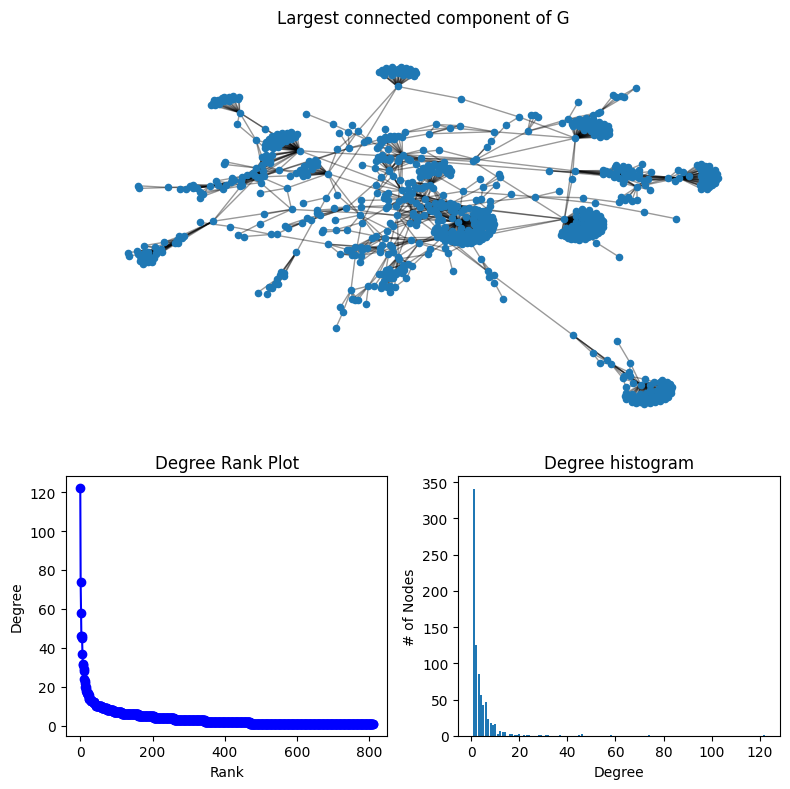

In [7]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Largest connected component of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

# Profil data understanding

In [8]:
# We use pandas dataframes to load attributes
# Nodes are characterized by a list of colleges, a list of employers, a list of location
# The order means nothing. Nothing allow us to determine the current employer...
df_e = pd.read_csv('employer_with_60percent_of_nodes_remoded.csv', sep='\t', header='infer')
df_e.head()

,name,employer
0,U1313,discovery education
1,U1313,ctb mcgraw-hill
2,U1313,university of charleston university of south c...
3,U1313,south carolina department of education
4,U1313,chesapeake va and sumter sc


In [9]:
df_e.groupby('name').count().describe()

,employer
count,297.000000
mean,3.107744
std,1.976682
min,1.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,13.000000


In [10]:
df_e['employer'].value_counts()

employer
university of illinois at urbana-champaign    76
google                                        15
microsoft                                     15
university of texas at austin                  5
amazon                                         5
                                              ..
new jersey department of education             1
brookings institution                          1
syrian emergency task force (setf)             1
muslim public affairs council                  1
yuhuan taijie hardware co. ltd.                1
Name: count, Length: 723, dtype: int64

In [11]:
# Boolean row selection by values in a column
df_e.loc[df_e['employer'].isin(['google','google inc']),:].head()


,name,employer
30,U3895,google
126,U15289,google
136,U24080,google
145,U24046,google
161,U7151,google


## Now, your turn!

Modify the previous cells, create your own noes to explore the dataset, and go on with the challenge. You need to understand how attributes are spread avor the nodes, as your first intuition is that neighbors tend to be similar. As you know "Birds of a feather flock together" (homophily theory in social network analysis).

Test here the homophily in the graph for each attribute


# We provide the baseline method to fill empty profiles, a naive implementation of the homophily theory

The assumption is that two connected nodes are likely to share the same attribute values. Here we choose the most frequently used attribute value among the neighbors.

Baseline method means that you will compare your own method with this one. Your job is to improve the quality of attribute predition. We will measure that in terms of precision.

In [12]:
naive_predicted_values={}

In [13]:
# Get a list from a Series
filled_nodes = df_e['name'].drop_duplicates().tolist()
print(f'{len(filled_nodes)*100/G.number_of_nodes():.2f} % of nodes have attributes (here employer attribute)')


36.62 % of nodes have attributes (here employer attribute)


In [14]:
#list difference, need the function `set()` to create sets ;-)
empty=set(G.nodes())-set(filled_nodes)
print(f'{len(empty)} empty nodes, without any attributes')

514 empty nodes, without any attributes


In [15]:
from collections import Counter

def naive_method(graph, empty, df):
    """   Predict the missing attribute with a simple but effective
    relational classifier. 
    
    The assumption is that two connected nodes are 
    likely to share the same attribute value. Here we chose the most frequently
    used attribute by the neighbors
    
    Parameters
    ----------
    graph : graph
       A networkx graph
    empty : list
       The nodes with empty attributes 
    df : pandas dataframe 
       Either location, employer or college dataframe. 

    Returns
    -------
    predicted_values : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node (from empty), value is a list of attribute values. Here 
       only 1 value in the list.
     """
    predicted_values={}
    for n in empty:
        nbrs_attr_values=[] 
        for node in graph.neighbors(n):
            # attribute values for the node node
            attr = df_e.loc[df_e.name == node ,'employer'].values
            if attr.size > 0: #array not empty
                for val in attr:
                    nbrs_attr_values.append(val)
        predicted_values[n]=[]
        if nbrs_attr_values: # non empty list
            # count the number of occurrence each value and returns a dict
            cpt=Counter(nbrs_attr_values)
            # take the most represented attribute value among neighbors
            a,nb_occurrence=max(cpt.items(), key=lambda t: t[1])
            predicted_values[n].append(a)
    return predicted_values


In [16]:
naive_predicted_values = naive_method(G, empty, df_e)

# Evaluation: let's assess the accuracy of our method

We need to compare the predicted attributes to the groundtruth, i.e. the expected attributes

In [17]:
df_e_truth = pd.read_csv('./groundtruth/employer.csv', sep='\t', header='infer')
df_e_truth.head()

,name,employer
0,U21998,illinois college advising corps
1,U21998,victoria amplifiers
2,U21998,university of illinois at chicago
3,U27476,ibm
4,U27476,nyse euronext


In [18]:
def evaluation_accuracy(groundtruth, pred):
    """    Compute the accuracy of your model.

     The accuracy is the proportion of true results.

    Parameters
    ----------
    groundtruth : pandas dataframe 
       Either location, employer or college dataframe. 
    pred : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values. 

    Returns
    -------
    out : float
       Accuracy.
    """
    true_positive_prediction=0
    predicted=0
    for p_key, p_value in pred.items():
        attr = groundtruth.loc[groundtruth.name == p_key ,groundtruth.columns[1]].values
        # if prediction is empty, e.g. [], and so is the groundtruth
        # May happen, we count it as a true prediction
        if not p_value and attr.size == 0:
            true_positive_prediction+=1
            predicted+=1
        # counts the number of good prediction for node p_key
        # here len(p_value)=1 but we could have tried to predict more values
        # if p_value == [], we add 0
        true_positive_prediction += len([c for c in p_value if c in attr])
        predicted += len([c for c in p_value])
    return true_positive_prediction*100/predicted
 

In [19]:
result=evaluation_accuracy(df_e_truth, naive_predicted_values)
print("%f%% of the predictions are true" % result)
print("Very poor result!!! Try to do better!!!!")

32.024169% of the predictions are true
Very poor result!!! Try to do better!!!!


## Now, your turn!

Provide here new strategies to fill the profiles and compare with the baseline